In [211]:
import argparse
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from utils import *
import torch
import torch.utils.data as Data

sns.set_style("white")

In [212]:
parser = argparse.ArgumentParser()

parser.add_argument('--path', type = str, default = 'input\Bitcoin Price.csv')
parser.add_argument('--label', type = str, default = 'Value')

parser.add_argument('--seq_size', type = float, default = 20)

parser.add_argument('--epochs', type = int, default = 1000)
parser.add_argument("--lr", type=float, default = 0.001)

parser.add_argument('--batch_size', type = int, default = 256)

parser.add_argument('--layer_size', type = int, default = 1)
parser.add_argument('--input_size', type = int, default = 8)
parser.add_argument('--hidden_size', type = int, default = 32)
parser.add_argument('--output_size', type = int, default = 1)

args = parser.parse_args(args=[])

In [213]:
df_train = pd.read_csv('input\BTC-USD.csv')

In [214]:
scaler = MinMaxScaler(feature_range=(-1, 1))
df_train['High'] = scaler.fit_transform(df_train['High'].values.reshape(-1,1))
df_train[args.label] = df_train['High']
df_train.drop(columns='High', inplace=True)

In [215]:
X, y = create_seq_data(df_train, args)
X, y = tranform_data(X, y, args.seq_size, args.input_size)

In [216]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

dataset = PriceDataSet(X, y)
data_loader = Data.DataLoader(
    dataset=dataset,
    batch_size=args.batch_size,
    shuffle=True,
    num_workers=0
)

In [217]:
# model = torch.load('models\LSTM_8_64_1.pkl').to(device)
# model = torch.load('models/res_LSTM.pkl').to(device)

model = resLSTM(args.input_size, args.hidden_size, args.layer_size, args.output_size).to(device)

criterion = torch.nn.MSELoss(size_average=True)

optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)

model

D:\Anaconda\envs\pytorch\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


resLSTM(
  (lstm): LSTM(8, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)

Epoch 1/1000
0 Train Loss: 214.3305
Epoch 2/1000
1 Train Loss: 76.7430
Epoch 3/1000
2 Train Loss: 95.6295
Epoch 4/1000
3 Train Loss: 104.7959
Epoch 5/1000
4 Train Loss: 66.7127
Epoch 6/1000
5 Train Loss: 55.1987
Epoch 7/1000
6 Train Loss: 59.3598
Epoch 8/1000
7 Train Loss: 54.7234
Epoch 9/1000
8 Train Loss: 49.1243
Epoch 10/1000
9 Train Loss: 71.2466
Epoch 11/1000
10 Train Loss: 49.9611
Epoch 12/1000
11 Train Loss: 52.7932
Epoch 13/1000
12 Train Loss: 40.9963
Epoch 14/1000
13 Train Loss: 72.8490
Epoch 15/1000
14 Train Loss: 73.8906
Epoch 16/1000
15 Train Loss: 40.2571
Epoch 17/1000
16 Train Loss: 44.3892
Epoch 18/1000
17 Train Loss: 44.9044
Epoch 19/1000
18 Train Loss: 32.3528
Epoch 20/1000
19 Train Loss: 39.8805
Epoch 21/1000
20 Train Loss: 50.6396
Epoch 22/1000
21 Train Loss: 48.0831
Epoch 23/1000
22 Train Loss: 44.3317
Epoch 24/1000
23 Train Loss: 76.2006
Epoch 25/1000
24 Train Loss: 65.2860
Epoch 26/1000
25 Train Loss: 57.3927
Epoch 27/1000
26 Train Loss: 40.4484
Epoch 28/1000
27 T

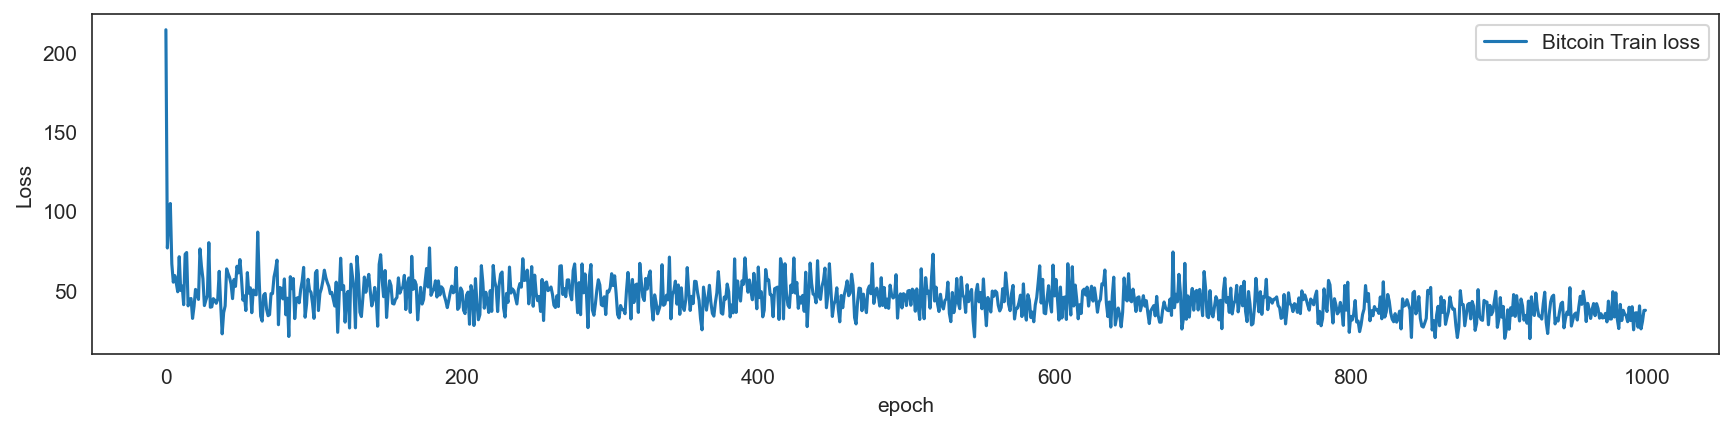

done


In [218]:
train_loss_all = []

for epoch in range(args.epochs):
    print('Epoch {}/{}'.format(epoch + 1, args.epochs))

    model.train()
    train_num = 0
    for (b_x, b_y) in data_loader:
        b_x = b_x.to(device)
        b_y = b_y.to(device)
        output = model(b_x)

        loss = criterion(output, b_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss += 100000 * loss.item() * b_x.size(0)
        train_num += b_x.size(0)
    train_loss_all.append(float(loss) / train_num)
    print('{} Train Loss: {:.4f}'.format(epoch, train_loss_all[-1]))


plt.figure(figsize=(14, 3), dpi=150)
sns.lineplot(data = train_loss_all, label = 'Bitcoin Train loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.savefig('results\Price_Prediction\Bitcoin Loss')
plt.show()
print('done')
torch.save(model, 'models/res_LSTM_bitcoin.pkl')

In [219]:
dataset = PriceDataSet(X, y)
data_loader = Data.DataLoader(
    dataset=dataset,
    batch_size=args.batch_size,
    shuffle=False,
    num_workers=0
)

In [220]:
df_pred = pd.read_csv(args.path).drop(columns='Unnamed: 0')
scaler = MinMaxScaler(feature_range=(-1, 1))
df_pred[args.label] = scaler.fit_transform(df_pred[args.label].values.reshape(-1,1))
X, y = tranform_data(*create_seq_data(df_pred, args), args.seq_size, args.input_size)

In [221]:
print(y.shape)
print(len(df_pred))

(1806, 1)
1826


In [222]:
model = model.to(torch.device('cpu'))

In [223]:
y_pred_std = model(torch.tensor(X, dtype=torch.float)).detach().numpy().reshape(-1,1)

In [224]:
y_pred = scaler.inverse_transform(y_pred_std)
y_label = scaler.inverse_transform(y.reshape(-1,1))

trainScore = mean_squared_error(y_pred, y_label, squared=True)
print('Score: %.2f RMSE' % (trainScore))

Score: 2285830.38 RMSE


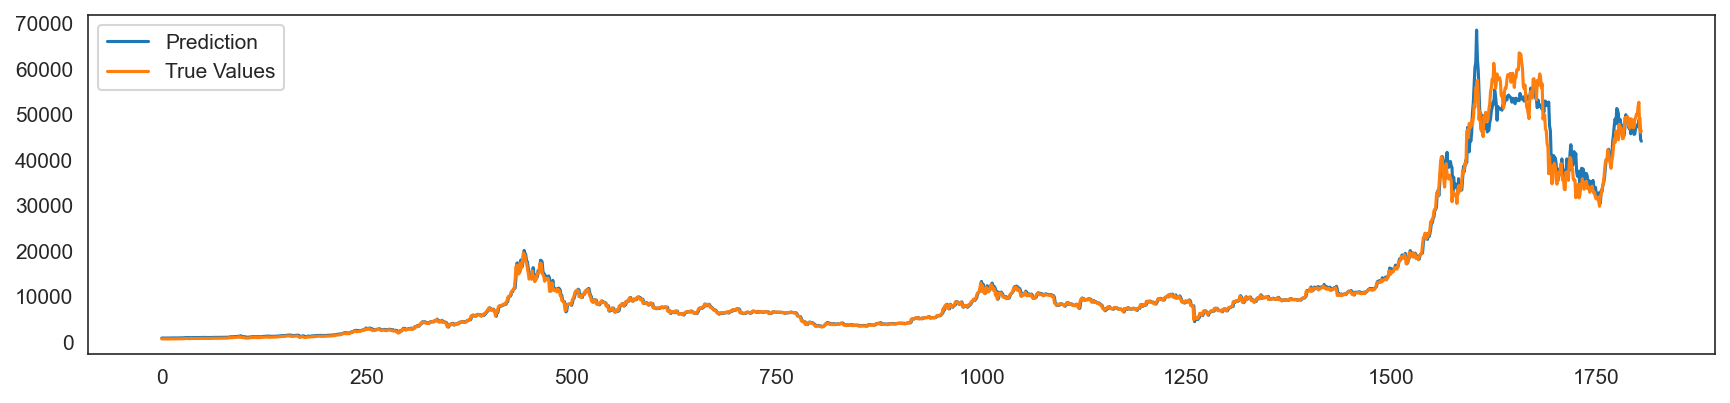

In [225]:
plt.figure(figsize=(14, 3), dpi=150)
plt.plot(y_pred, label = 'Prediction')
plt.plot(y_label, label = 'True Values')
plt.legend()
plt.show()

In [226]:
result = {'Price': y_label.flatten(), 'Day 1 Prediction': y_pred.flatten()}

In [227]:
X = create_seq_data_for_day_2(df_pred[args.label].values, y_pred_std, args)

g:\2022_MCM\utils.py:174: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data_feat = np.array(data_feat)


In [228]:
pred_y_std = model(torch.tensor(X, dtype=torch.float)).detach().numpy().reshape(-1,1)
y_pred = scaler.inverse_transform(pred_y_std).flatten()
mean_squared_error(result['Price'][1:], y_pred, squared=True)

5108059.571803734

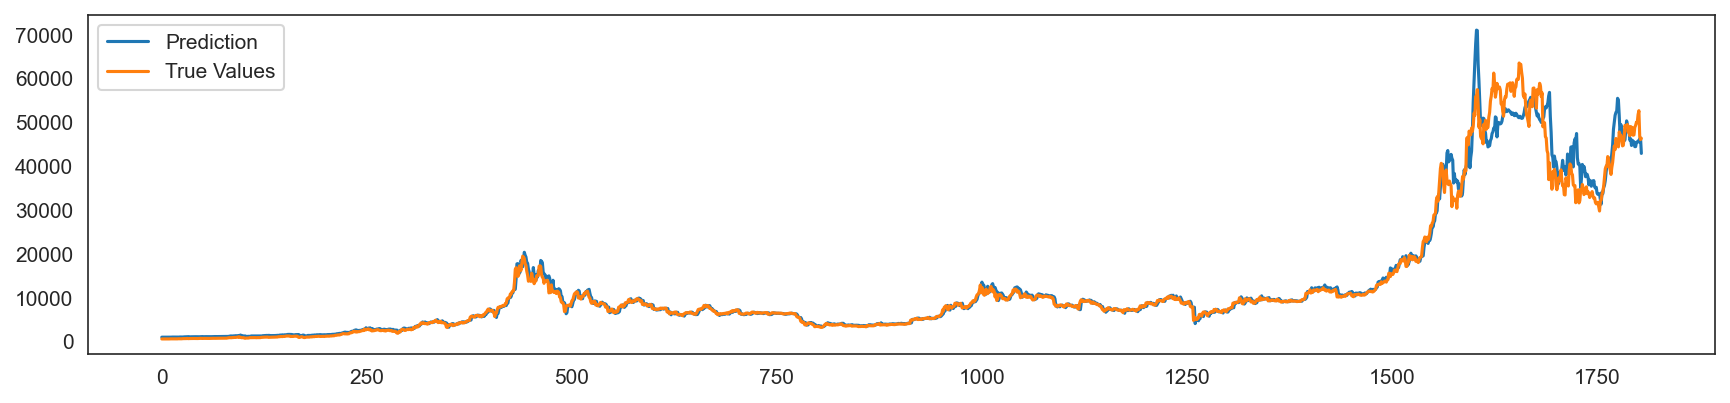

In [229]:
plt.figure(figsize=(14, 3), dpi=150)
plt.plot(y_pred, label = 'Prediction')
plt.plot(result['Price'][1:], label = 'True Values')
plt.legend()
plt.show()

In [230]:
result['Day 2 Prediction'] = y_pred

In [231]:
X = create_seq_data_for_day_3(df_pred[args.label].values, scaler.transform(result['Day 1 Prediction'].reshape(-1, 1)), scaler.transform(result['Day 2 Prediction'].reshape(-1, 1)), args)

g:\2022_MCM\utils.py:184: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data_feat = np.array(data_feat)


In [232]:
pred_y_std = model(torch.tensor(X, dtype=torch.float)).detach().numpy().reshape(-1,1)
y_pred = scaler.inverse_transform(pred_y_std).flatten()
mean_squared_error(result['Price'][2:], y_pred, squared=True)

6962769.6515349895

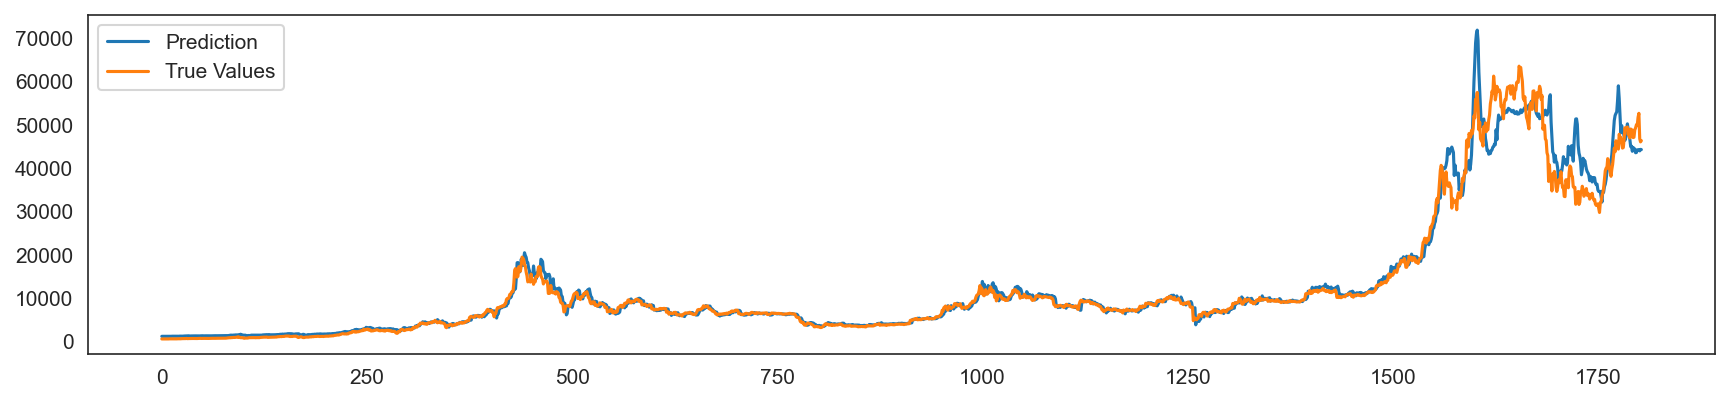

In [233]:
plt.figure(figsize=(14, 3), dpi=150)
plt.plot(y_pred, label = 'Prediction')
plt.plot(result['Price'][2:], label = 'True Values')
plt.legend()
plt.show()

In [234]:
result['Day 3 Prediction'] = y_pred.flatten()

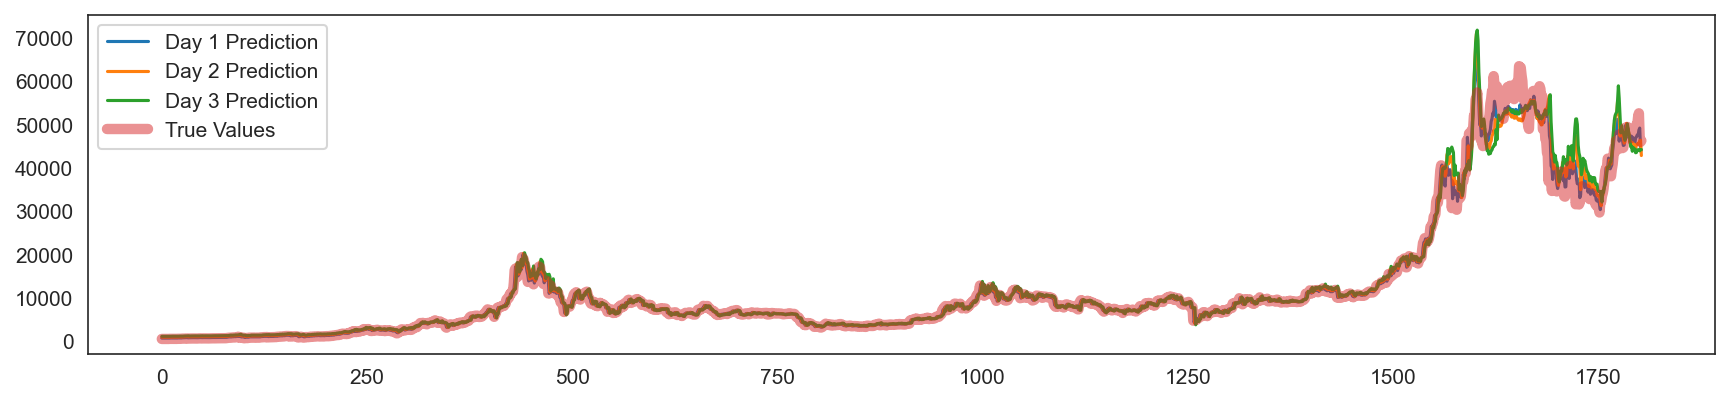

In [235]:
plt.figure(figsize=(14, 3), dpi=150)
plt.plot(result['Day 1 Prediction'][2:], label = 'Day 1 Prediction')
plt.plot(result['Day 2 Prediction'][1:], label = 'Day 2 Prediction')
plt.plot(result['Day 3 Prediction'], label = 'Day 3 Prediction')
plt.plot(result['Price'][2:], label = 'True Values', linewidth = 5, alpha = 0.5)
plt.legend()
plt.show()

In [236]:
df_dic = {}
df_dic['Day 1 Prediction'] = result['Day 1 Prediction'][2:]
df_dic['Day 2 Prediction'] = result['Day 2 Prediction'][1:]
df_dic['Day 3 Prediction'] = result['Day 3 Prediction']
df_dic['Price'] = result['Price'][2:]
df = pd.DataFrame(df_dic)
df.to_csv('results\Price_Prediction\prediction bitcoin price.csv')

In [237]:
df

,Day 1 Prediction,Day 2 Prediction,Day 3 Prediction,Price
0,812.762817,1019.982971,1219.954712,611.85
1,811.552612,1017.789490,1225.255371,609.62
2,809.270935,1016.554810,1223.037598,607.18
3,806.822266,1014.269409,1221.799194,612.08
4,811.933472,1011.837646,1219.532471,617.21
...,...,...,...,...
1799,47510.843750,45771.839844,44261.964844,51769.06
1800,48790.792969,45538.085938,44308.535156,52677.40
1801,49270.023438,46313.300781,44007.777344,46809.17
1802,44566.058594,46469.230469,44359.945312,46078.38


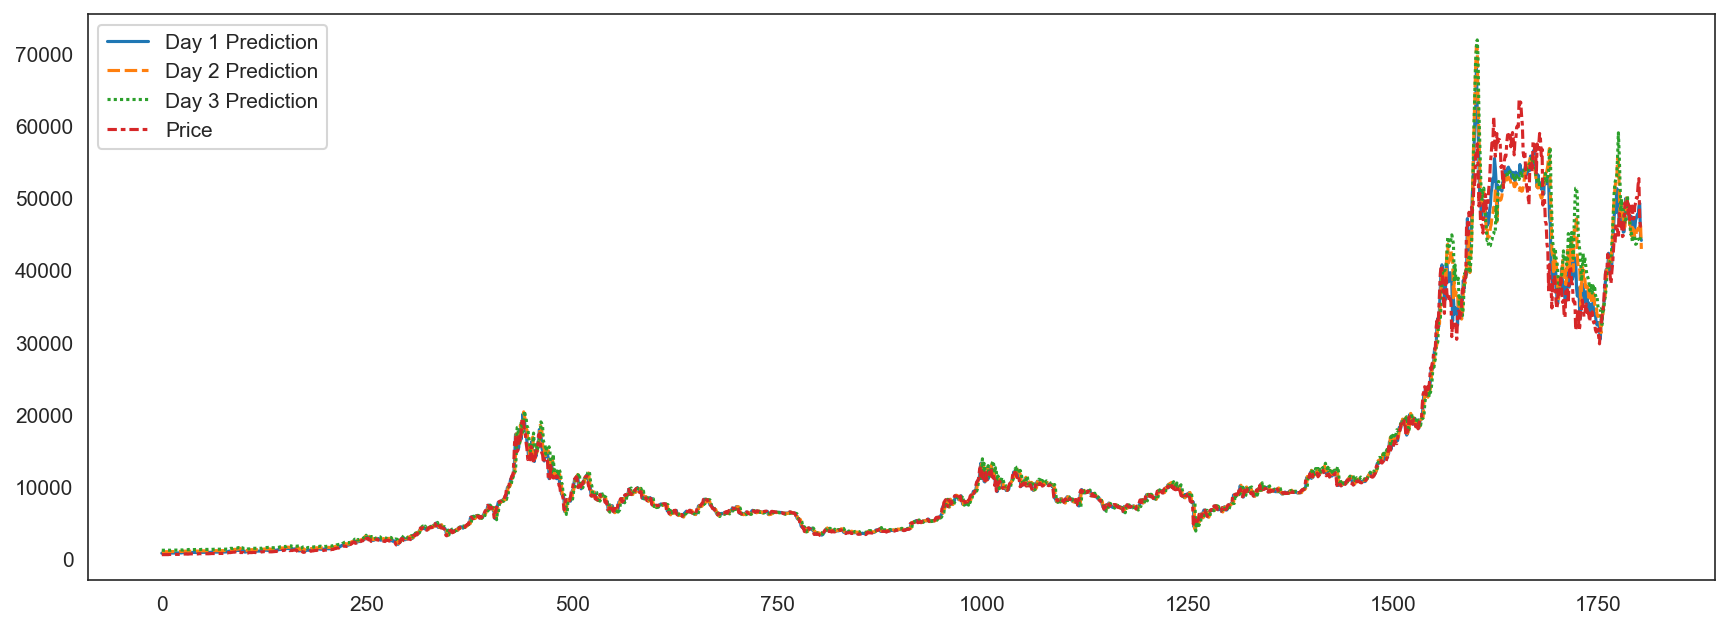

In [238]:
plt.figure(figsize=(14, 5), dpi=150)
sns.lineplot(data=df)
plt.savefig('results\Price_Prediction/bitcoin price prediction.jpg')

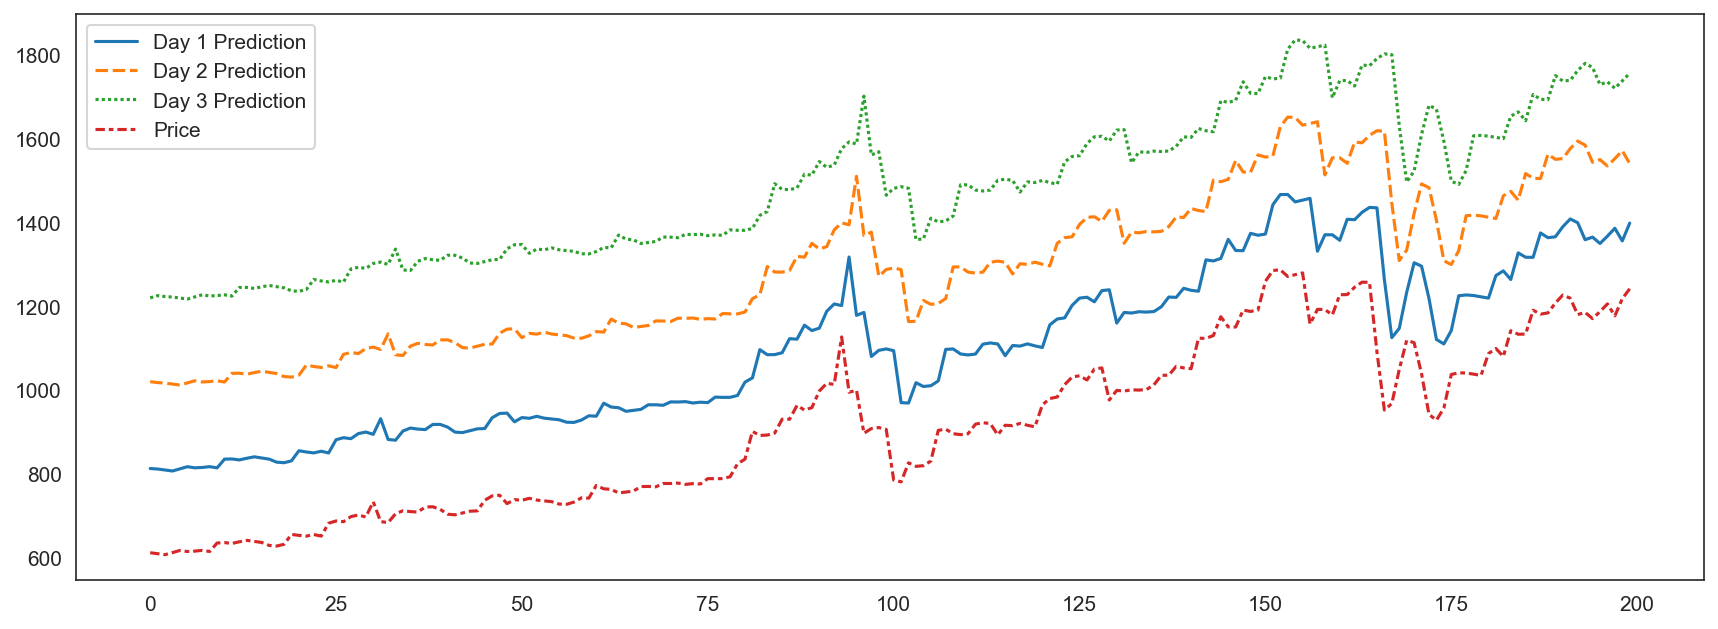

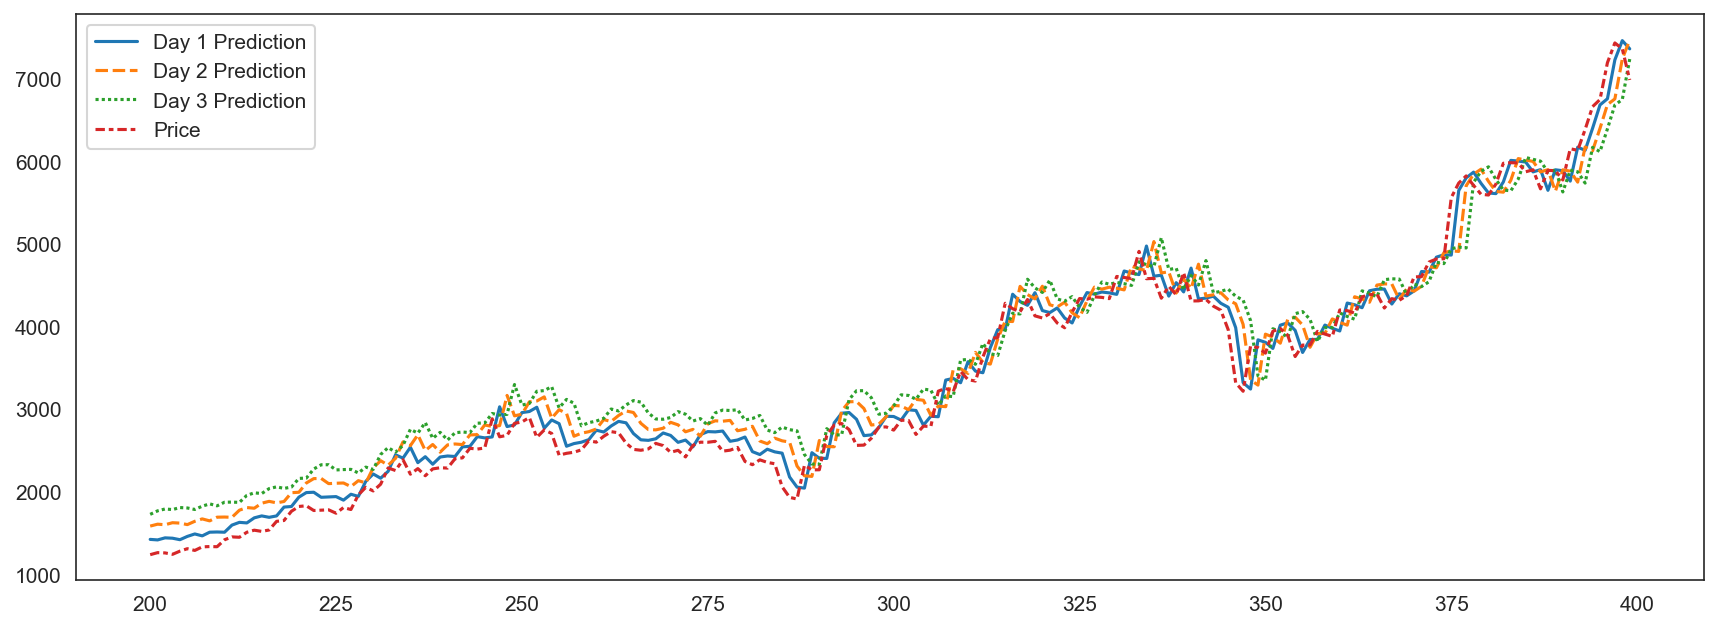

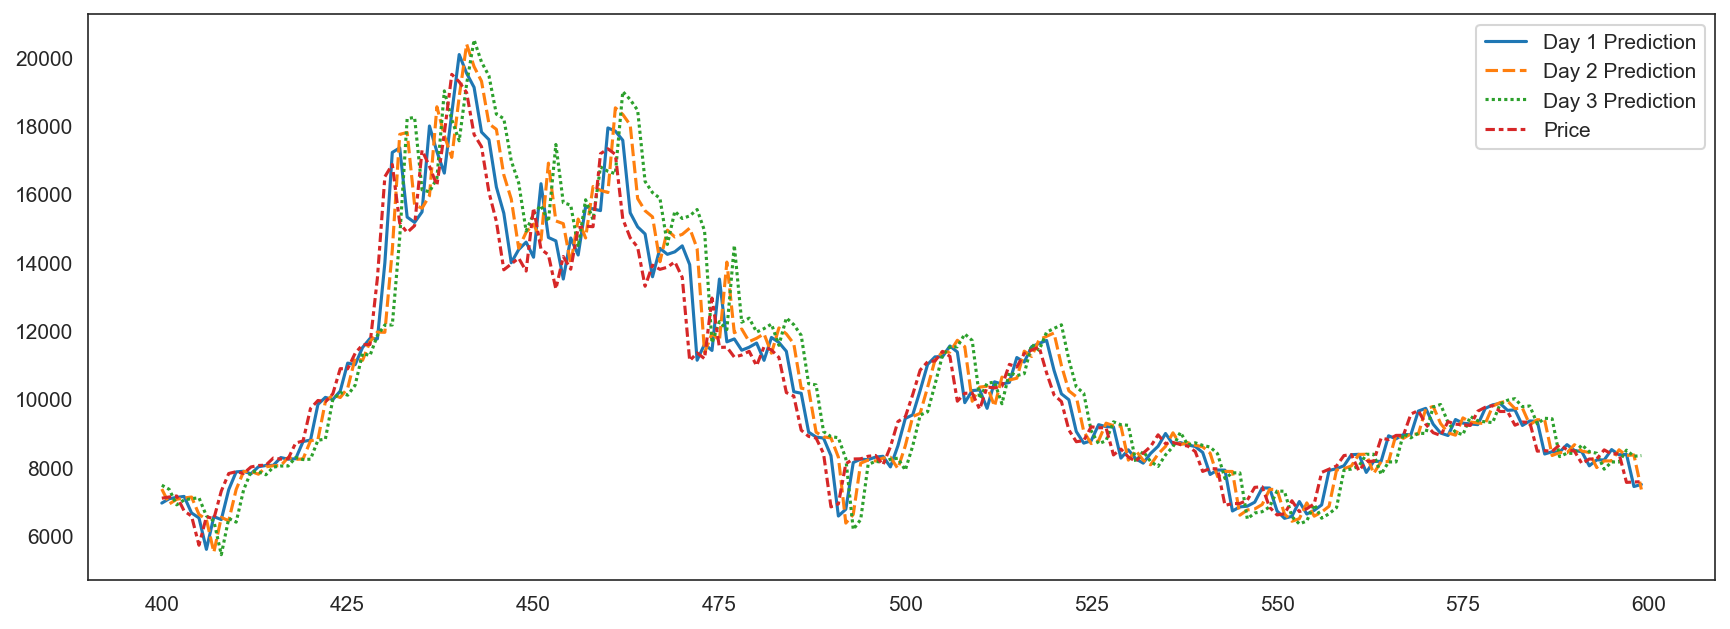

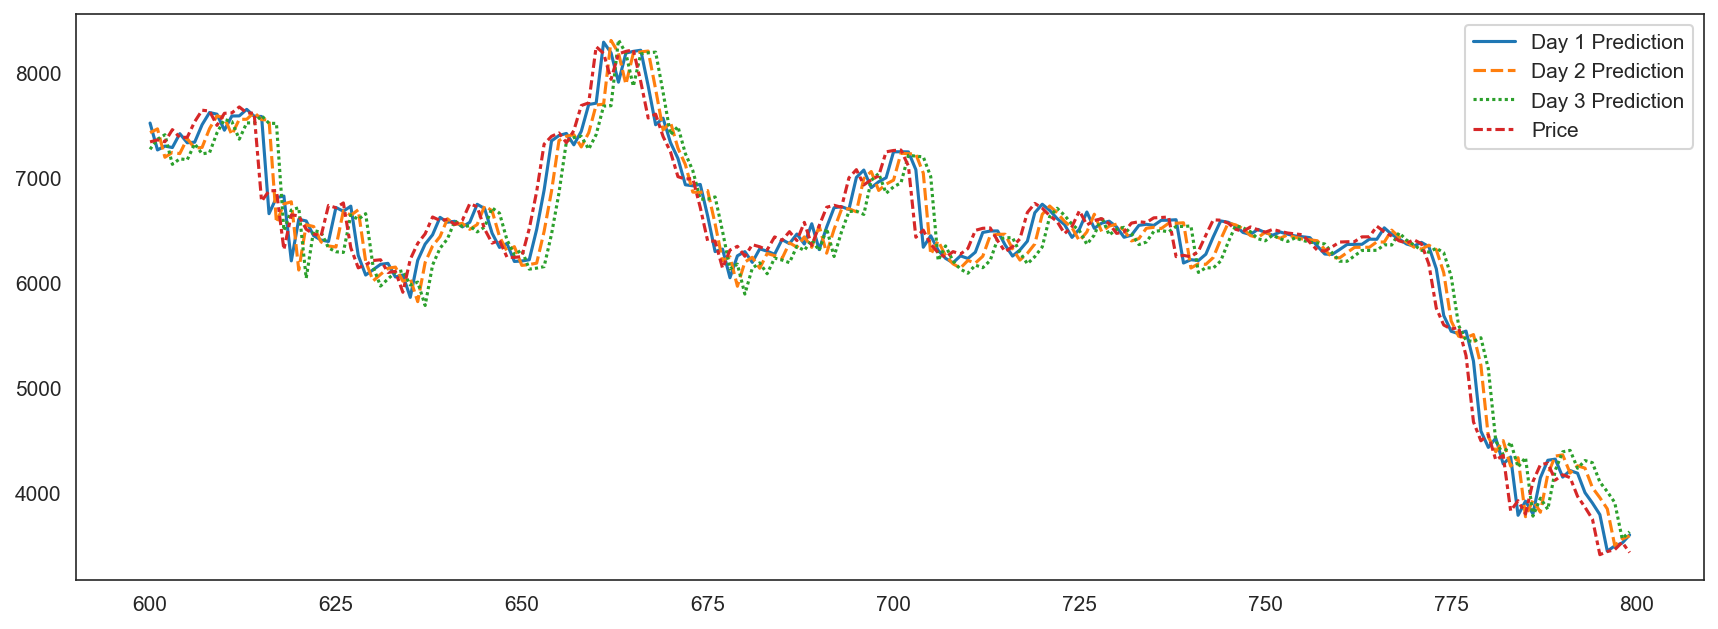

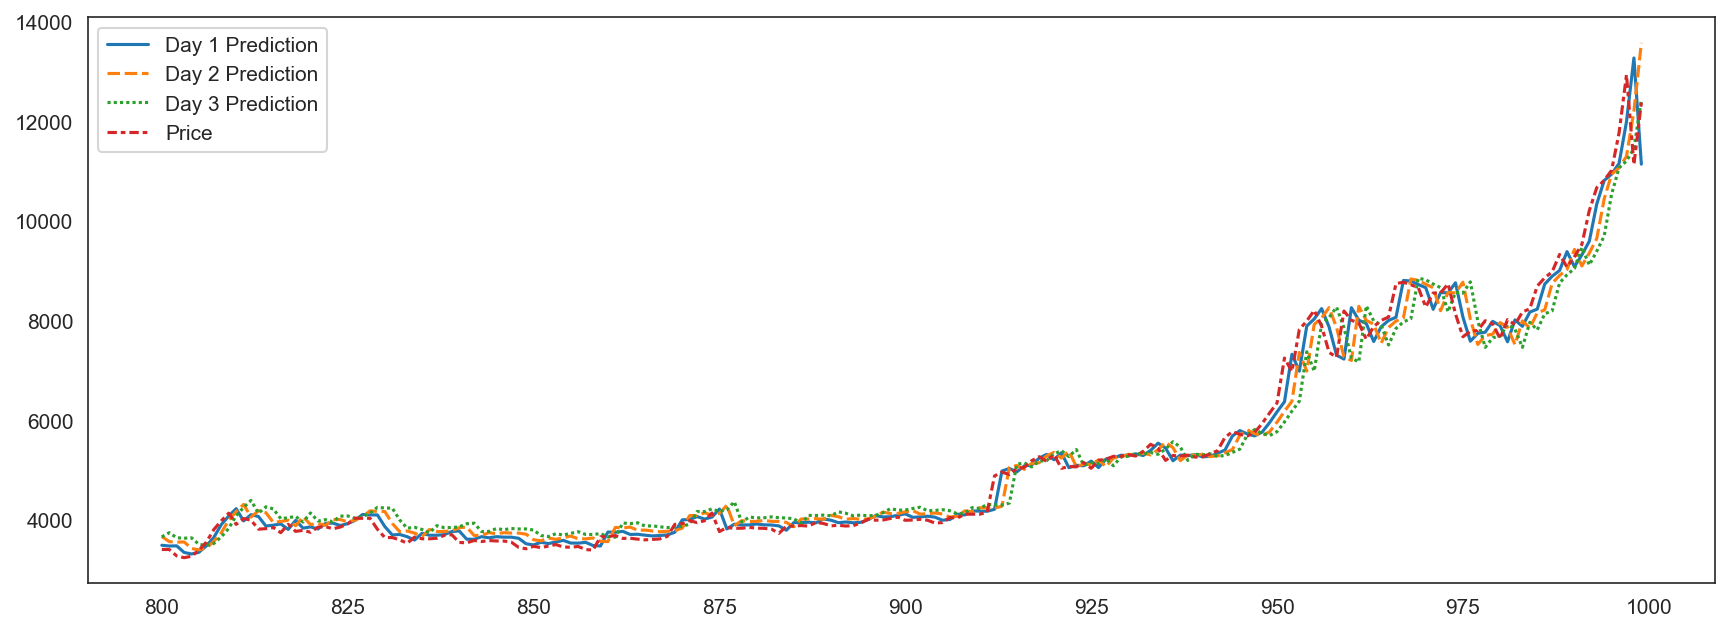

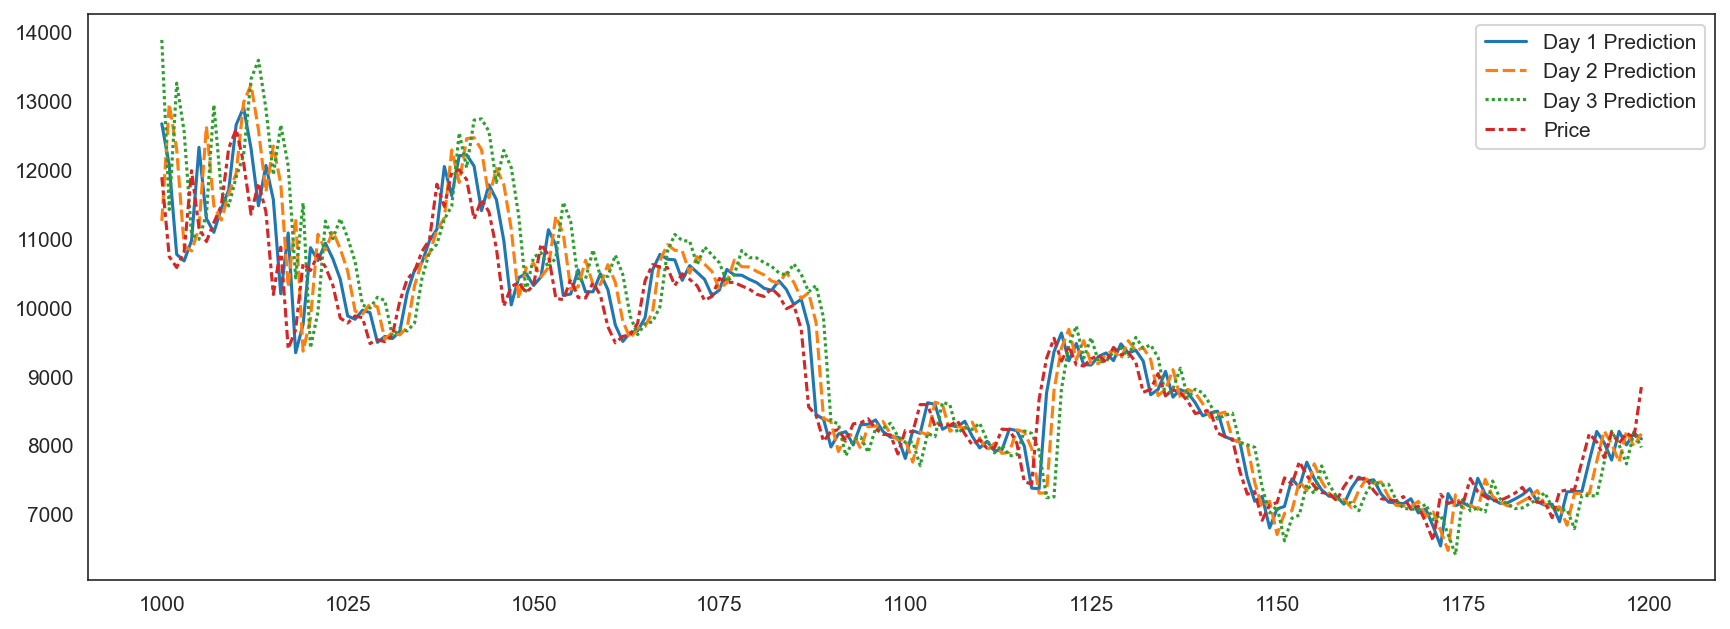

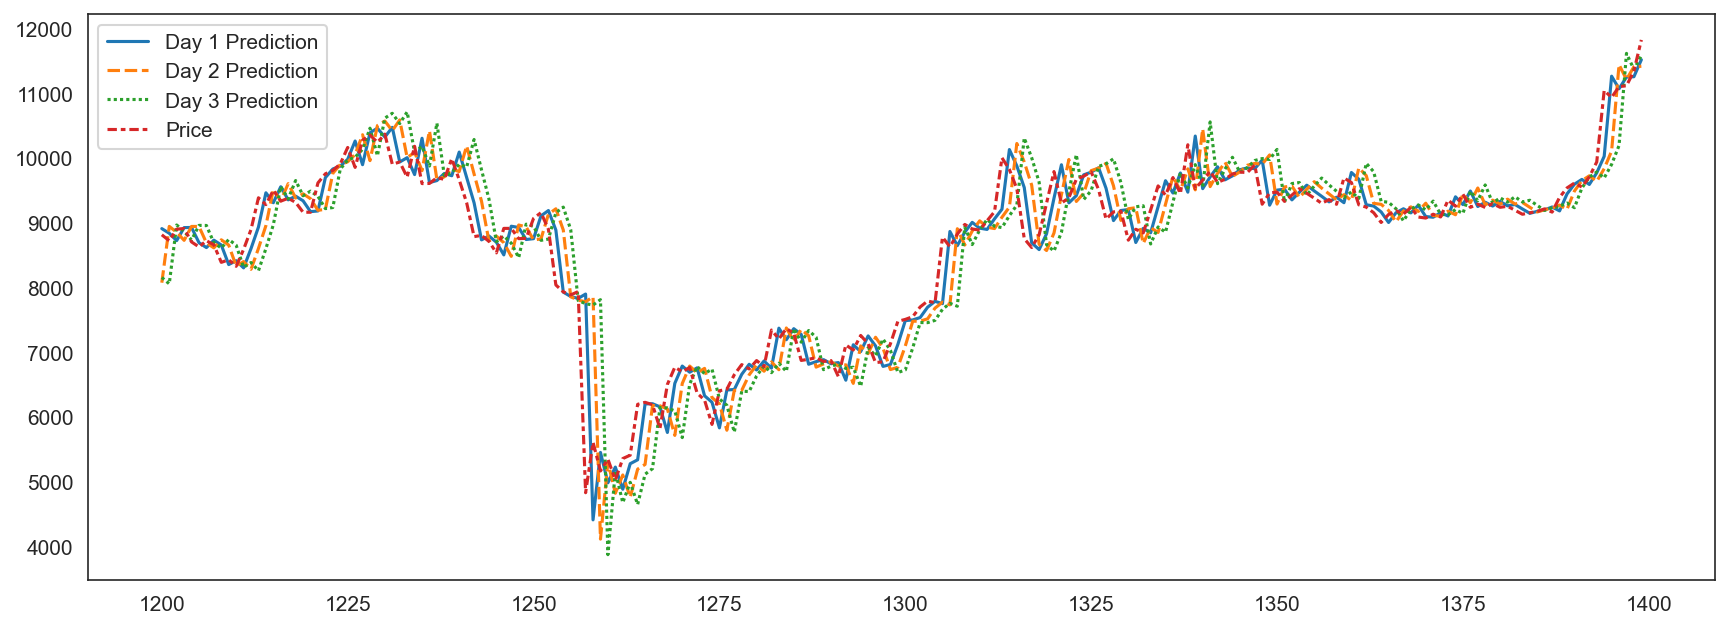

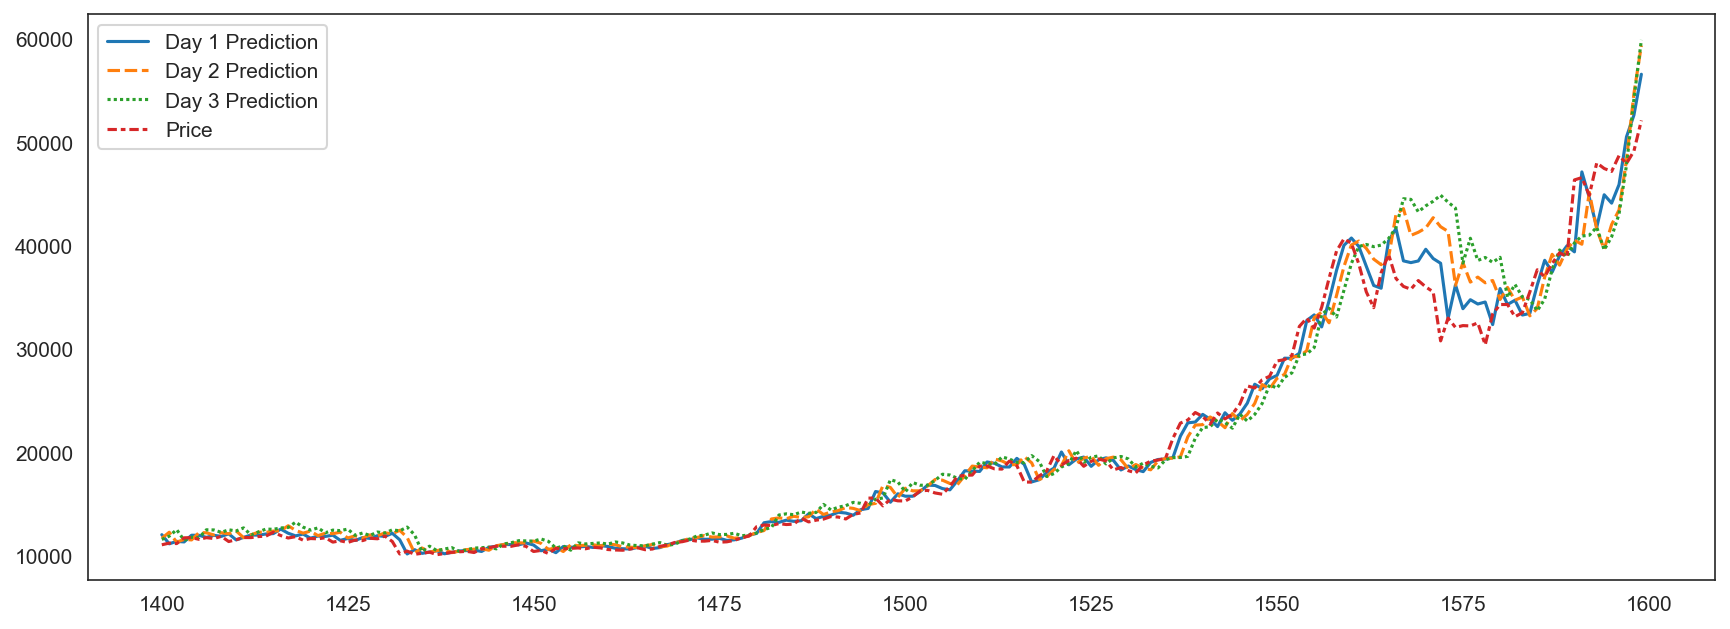

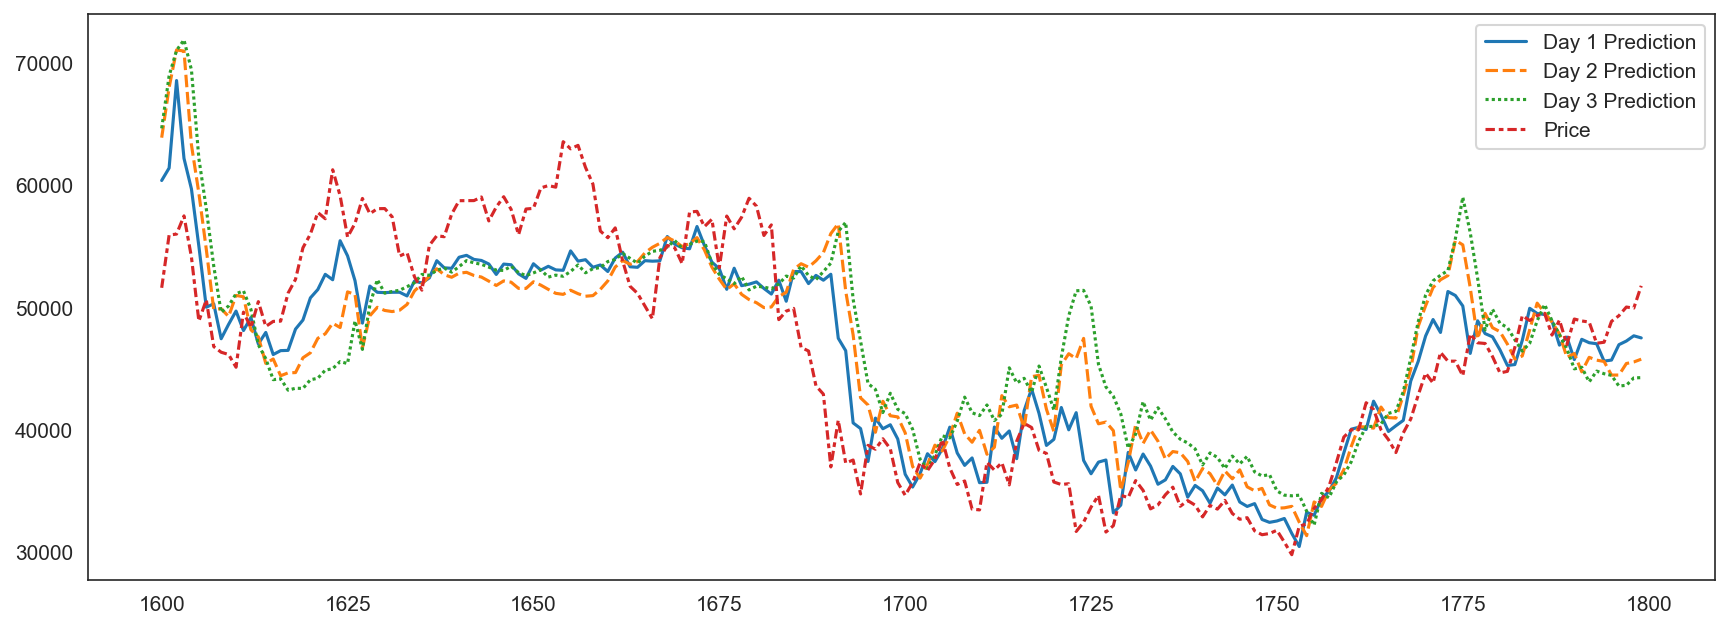

In [239]:
interval = 200
for i in range(len(df_dic['Price']) // interval):
    plt.figure(figsize=(14, 5), dpi=150)
    sns.lineplot(data=df[i * interval: (i + 1) * interval])
    plt.savefig(f'results\Price_Prediction/bitcoin price prediction {i}th.jpg')